# Project: US Gun Permit Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> The purpose of this analysis is to know the relation between the gun permits on US and parameters as the states, health insurance, educational level or wealth level. 
Does the application for weapons permits depend on the educational or wealth level?
Witch state has the highest number of gun owners? Witch the lowest? What differences are ther between this two states?

In [77]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

> We load the information of American census with the properties that interest us (Population, Graduate(%), Degree(%), No Insurance(%), Incomes($), Poverty(%))

In [78]:
df_census = pd.read_csv("U.S. Census Data.csv")
df_census.columns.str.strip()

#Get population
population = df_census.iloc[0]
#Get high school graduate or higher, percent
graduatePercent = df_census.iloc[34]
#Get bachelor's degree or higher, percent
degreePercent = df_census.iloc[35]
#Get persons without health insurance, percent
noInsurancePercent = df_census.iloc[37]
#Get per capita incomes
incomes = df_census.iloc[48]
#Get persons in poverty, percent
povertyPercent = df_census.iloc[49]

df_custom_census = pd.concat([population, graduatePercent, degreePercent, noInsurancePercent, incomes, povertyPercent]
                             , keys=['Population','Graduate(%)','Degree(%)','No Insurance(%)','Incomes($)','Poverty(%)']
                             , axis=1)
df_custom_census.drop(['Fact','Fact Note'], inplace=True)
df_custom_census.index.name = 'State'

In [79]:
df_custom_census.head()

,Population,Graduate(%),Degree(%),No Insurance(%),Incomes($),Poverty(%)
State,,,,,,
Alabama,"4,863,300",84.30%,23.50%,10.70%,"$24,091",17.10%
Alaska,"741,894",92.10%,28.00%,15.50%,"$33,413",9.90%
Arizona,"6,931,071",86.00%,27.50%,11.90%,"$25,848",16.40%
Arkansas,"2,988,248",84.80%,21.10%,9.30%,"$22,798",17.20%
California,"39,250,017",81.80%,31.40%,8.30%,"$30,318",14.30%


In [80]:
df_custom_census.shape

(50, 6)

In [81]:
df_custom_census.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 6 columns):
Population         50 non-null object
Graduate(%)        50 non-null object
Degree(%)          50 non-null object
No Insurance(%)    50 non-null object
Incomes($)         50 non-null object
Poverty(%)         50 non-null object
dtypes: object(6)
memory usage: 2.7+ KB


> We load the information of Gun Data of the last year with the properties that interest us (state and handgun)

In [82]:
df_gunData = pd.read_excel("gun_data.xlsx")
df_gunData.columns.str.strip()

#Filter per month, state and permit
df_gunData = df_gunData[['month','state','handgun']]

#Filter data for last 1 year (column month). From 2016,10 to 2017,09
#Grouped by "state" performing the average of rest of columns
df_gunData_grouped = df_gunData[df_gunData['month'] > '2016-10'].groupby(['state']).mean()
df_gunData_grouped.index.name = 'State'
df_gunData_grouped.columns = ['Handgun']

In [83]:
df_gunData_grouped.head()

,Handgun
State,
Alabama,8430.181818
Alaska,2916.272727
Arizona,13132.090909
Arkansas,6134.090909
California,45531.272727


In [84]:
df_gunData_grouped.shape

(55, 1)

In [85]:
df_gunData_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, Alabama to Wyoming
Data columns (total 1 columns):
Handgun    55 non-null float64
dtypes: float64(1)
memory usage: 880.0+ bytes


> Concatenate the two dataSet

In [86]:
df = pd.concat([df_custom_census, df_gunData_grouped], join='inner', axis=1)

In [87]:
df.head()

,Population,Graduate(%),Degree(%),No Insurance(%),Incomes($),Poverty(%),Handgun
State,,,,,,,
Alabama,"4,863,300",84.30%,23.50%,10.70%,"$24,091",17.10%,8430.181818
Alaska,"741,894",92.10%,28.00%,15.50%,"$33,413",9.90%,2916.272727
Arizona,"6,931,071",86.00%,27.50%,11.90%,"$25,848",16.40%,13132.090909
Arkansas,"2,988,248",84.80%,21.10%,9.30%,"$22,798",17.20%,6134.090909
California,"39,250,017",81.80%,31.40%,8.30%,"$30,318",14.30%,45531.272727


In [88]:
df.shape

(50, 7)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 7 columns):
Population         50 non-null object
Graduate(%)        50 non-null object
Degree(%)          50 non-null object
No Insurance(%)    50 non-null object
Incomes($)         50 non-null object
Poverty(%)         50 non-null object
Handgun            50 non-null float64
dtypes: float64(1), object(6)
memory usage: 3.1+ KB


### Data Cleaning

> We review the data by formatting them to numerals
It is necessary that we remove characters such as ($,%), homogenize some percentages (relative to 1 instead of 100) and eliminate values out of 25-75% on handgun values that may be poorly acquired.

In [90]:
#Check the data
df

,Population,Graduate(%),Degree(%),No Insurance(%),Incomes($),Poverty(%),Handgun
State,,,,,,,
Alabama,"4,863,300",84.30%,23.50%,10.70%,"$24,091",17.10%,8430.181818
Alaska,"741,894",92.10%,28.00%,15.50%,"$33,413",9.90%,2916.272727
Arizona,"6,931,071",86.00%,27.50%,11.90%,"$25,848",16.40%,13132.090909
Arkansas,"2,988,248",84.80%,21.10%,9.30%,"$22,798",17.20%,6134.090909
California,"39,250,017",81.80%,31.40%,8.30%,"$30,318",14.30%,45531.272727
Colorado,"5,540,545",90.70%,38.10%,8.60%,"$32,217",11.00%,19281.454545
Connecticut,"3,576,452",89.90%,37.60%,5.70%,"$38,803",9.80%,6309.454545
Delaware,"952,065",88.40%,30.00%,6.60%,"$30,554",11.70%,1980.727273
Florida,"20,612,439",86.90%,27.30%,15.30%,"$26,829",14.70%,53799.454545


> We can see some issues on the format of the data
- Percentage field without % shall be multiplied by 100
- Population. Comma shall be removed
- The incomes without $ look like fine
- Hawaii has 0 handgun. It look like an error on the data


In [91]:
#Remove %, $ y ',
removeComma = lambda x: x.replace(',','')
removePer = lambda x: float(x)*100 if not '%' in x else x.replace('%','')
removeDollar = lambda x: x.replace('$','')

df['Population'] = df['Population'].apply(removeComma)
df['Graduate(%)'] = df['Graduate(%)'].apply(removePer)
df['Degree(%)'] = df['Degree(%)'].apply(removePer)
df['No Insurance(%)'] = df['No Insurance(%)'].apply(removePer)
df['Incomes($)'] = df['Incomes($)'].apply(removeDollar).apply(removeComma)
df['Poverty(%)'] = df['Poverty(%)'].apply(removePer)

df.drop('Hawaii', inplace=True)

df = df.apply(pd.to_numeric)

In [92]:
#Add column Handgun/Population
df['Handgun Density'] = df['Handgun']/df['Population']
df['Handgun Density'].describe()

count    49.000000
mean      0.002211
std       0.001060
min       0.000073
25%       0.001691
50%       0.002231
75%       0.002934
max       0.004054
Name: Handgun Density, dtype: float64

In [93]:
#Clean <25% or >75% Handgun data
filtered_df=df[df['Handgun Density'] >= 0.001691]
filtered_df=filtered_df[filtered_df['Handgun Density'] <= 0.004054]
filtered_df.head()

,Population,Graduate(%),Degree(%),No Insurance(%),Incomes($),Poverty(%),Handgun,Handgun Density
State,,,,,,,,
Alabama,4863300,84.3,23.5,10.7,24091,17.1,8430.181818,0.001733
Alaska,741894,92.1,28.0,15.5,33413,9.9,2916.272727,0.003931
Arizona,6931071,86.0,27.5,11.9,25848,16.4,13132.090909,0.001895
Arkansas,2988248,84.8,21.1,9.3,22798,17.2,6134.090909,0.002053
Colorado,5540545,90.7,38.1,8.6,32217,11.0,19281.454545,0.003480


In [94]:
print (filtered_df['Handgun Density'].describe())
print ("STD/MEAN: {0}".format(filtered_df['Handgun Density'].std()/filtered_df['Handgun Density'].mean()))

count    37.000000
mean      0.002680
std       0.000711
min       0.001691
25%       0.002147
50%       0.002585
75%       0.003177
max       0.004054
Name: Handgun Density, dtype: float64
STD/MEAN: 0.265157208028867


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58a49272e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f58a4cd2cc0>]], dtype=object)

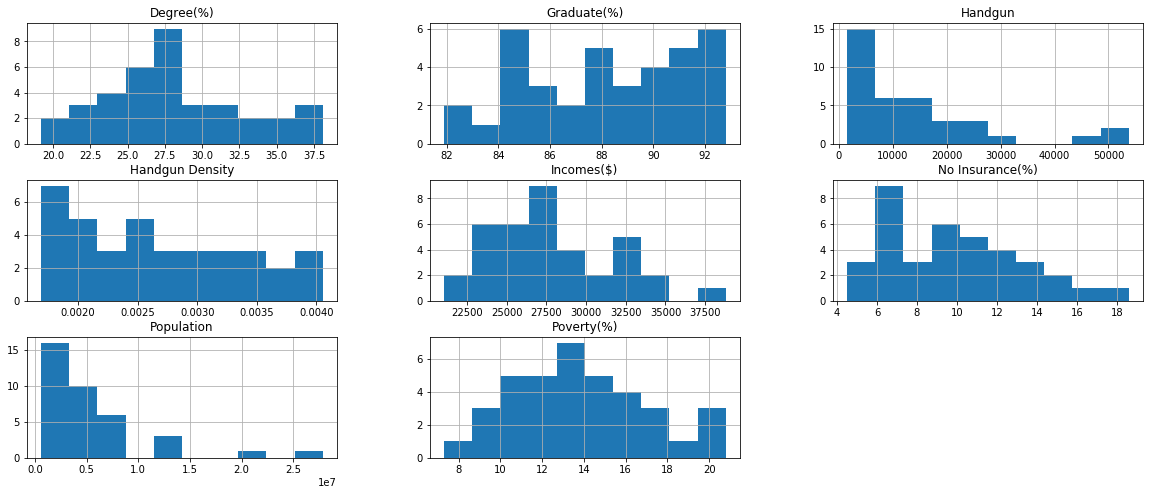

In [95]:
filtered_df.hist(figsize=(20,8))

<a id='eda'></a>
## Exploratory Data Analysis

### Is there a relationship between the density of small arms and poverty, education or sanitary security?

count    37.000000
mean      0.000099
std       0.000032
min       0.000047
25%       0.000074
50%       0.000093
75%       0.000116
max       0.000195
dtype: float64
STD/MEAN: 0.32428872053145963


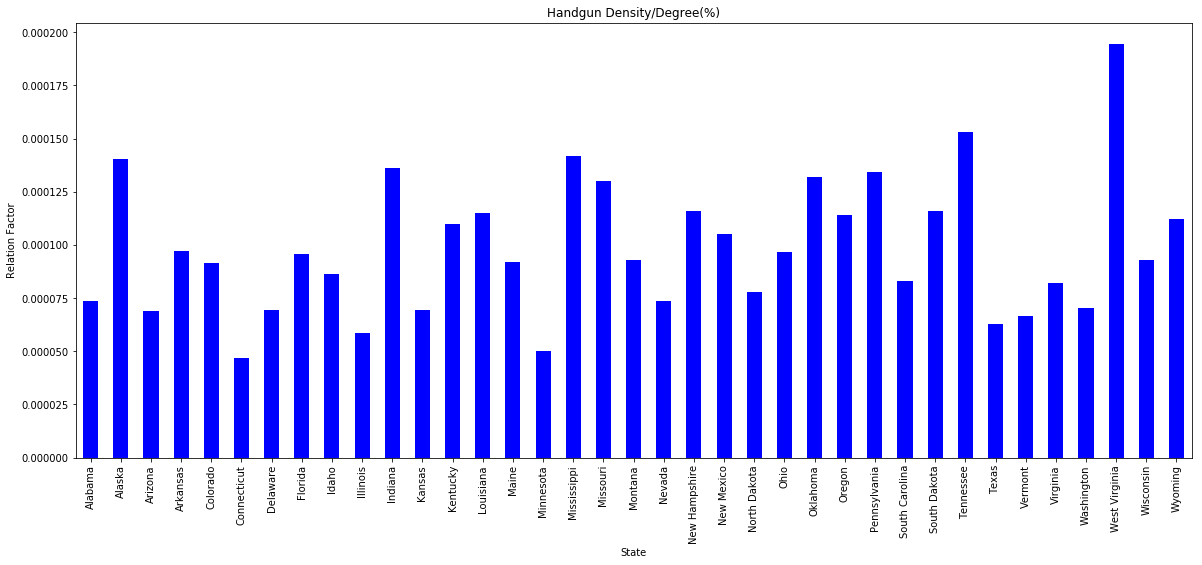

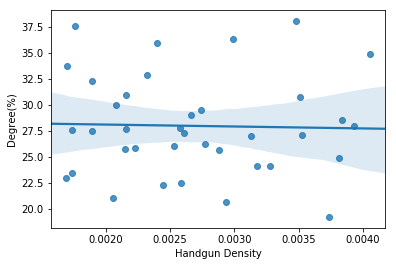

In [96]:
result = filtered_df['Handgun Density']/filtered_df['Degree(%)']
print (result.describe())
print ("STD/MEAN: {0}".format(result.std()/result.mean()))
result.plot(kind='bar',figsize=(20,8),color='blue',title='Handgun Density/Degree(%)')
plt.ylabel("Relation Factor")
plt.show()
sns.regplot(x=filtered_df['Handgun Density'], y=filtered_df['Degree(%)'])

> It seems that a university degree does not affect to the handgun density

count    37.000000
mean      0.000030
std       0.000008
min       0.000018
25%       0.000024
50%       0.000029
75%       0.000037
max       0.000045
dtype: float64
STD/MEAN: 0.2602836996354789


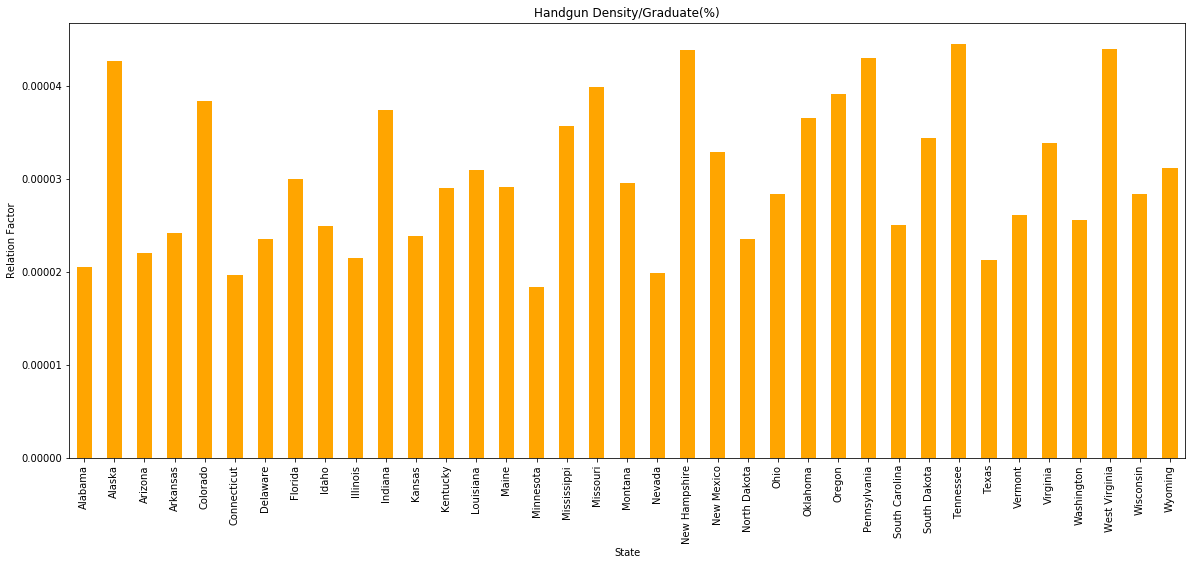

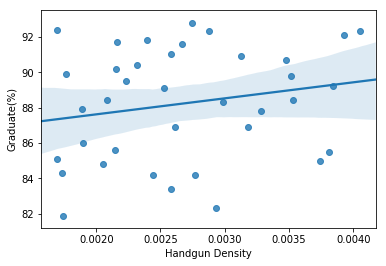

In [97]:
result = filtered_df['Handgun Density']/filtered_df['Graduate(%)']
print (result.describe())
print ("STD/MEAN: {0}".format(result.std()/result.mean()))
result.plot(kind='bar',figsize=(20,8),color='orange',title='Handgun Density/Graduate(%)')
plt.ylabel("Relation Factor")
plt.show()
sns.regplot(x=filtered_df['Handgun Density'], y=filtered_df['Graduate(%)'])

> It seems that there is a slight correlation and the density of handgun increases with the increase in the number of high school graduates.
Although we could hope otherwise.

count    37.000000
mean      0.000304
std       0.000126
min       0.000093
25%       0.000213
50%       0.000280
75%       0.000360
max       0.000575
dtype: float64
STD/MEAN: 0.4154225964301723


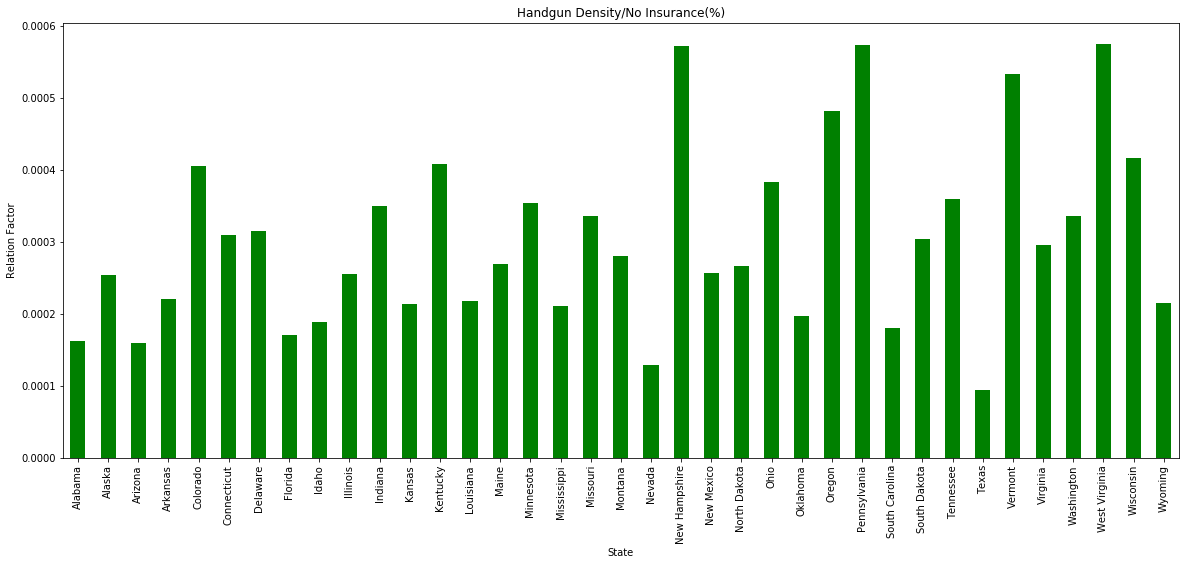

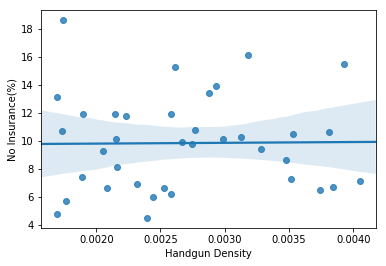

In [98]:
result = filtered_df['Handgun Density']/filtered_df['No Insurance(%)']
print (result.describe())
print ("STD/MEAN: {0}".format(result.std()/result.mean()))
result.plot(kind='bar',figsize=(20,8),color='green',title='Handgun Density/No Insurance(%)')
plt.ylabel("Relation Factor")
plt.show()
sns.regplot(x=filtered_df['Handgun Density'], y=filtered_df['No Insurance(%)'])

> It seems that the percentage of population with health insurance does not affect to the handgun density

count    37.000000
mean      0.000205
std       0.000087
min       0.000101
25%       0.000141
50%       0.000195
75%       0.000235
max       0.000555
dtype: float64
STD/MEAN: 0.42521397120159865


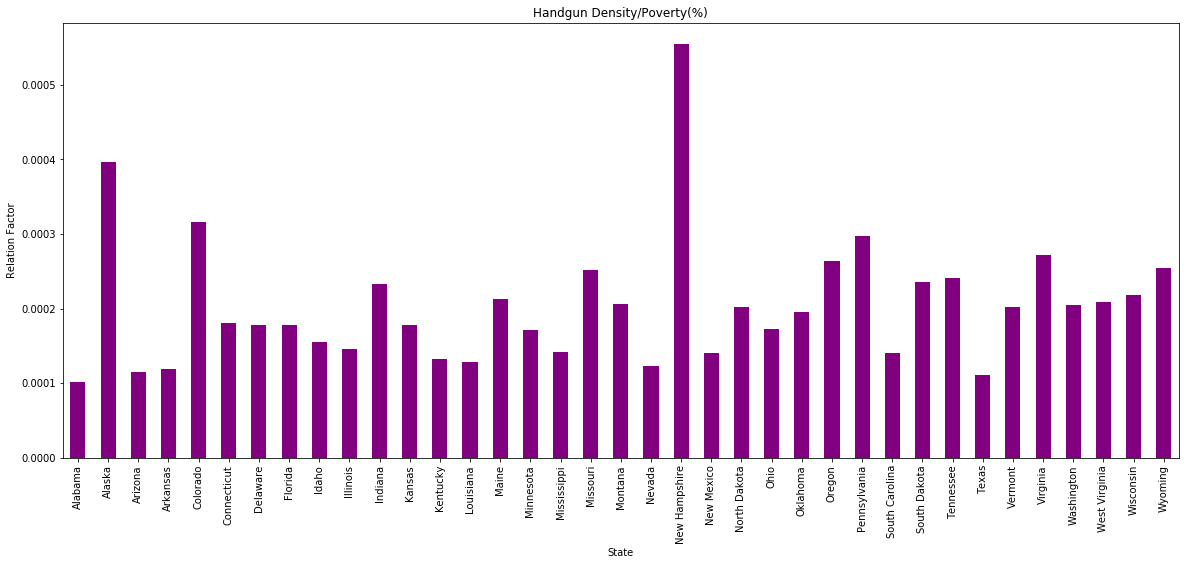

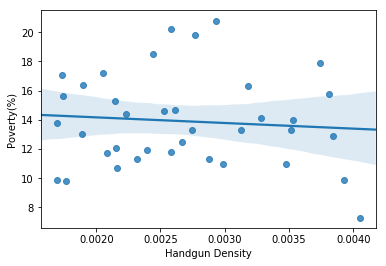

In [99]:
result = filtered_df['Handgun Density']/filtered_df['Poverty(%)']
print (result.describe())
print ("STD/MEAN: {0}".format(result.std()/result.mean()))
result.plot(kind='bar',figsize=(20,8),color='purple',title='Handgun Density/Poverty(%)')
plt.ylabel("Relation Factor")
plt.show()
sns.regplot(x=filtered_df['Handgun Density'], y=filtered_df['Poverty(%)'])

> It seems that there is a slight correlation and the handgun density increases slightly with the decrease in poverty. Although we could also expect the opposite

> It can be seen that none of the variables significantly affects the density of small arms. Although there is a small relationship between the level of studies and wealth. Affecting the increase of both to a slight increase in the density of the number of weapons

###  What variable of the above affects more the density of small handgun?

> The STD/MEAN for the density of short weapons is 0.265
The only variable that reduces (0.260) the previous value is education (Graduate on High School)

### Witch state has the highest number of gun owners? Witch the lowest? What differences are ther between this two states?

Text(0,0.5,'States')

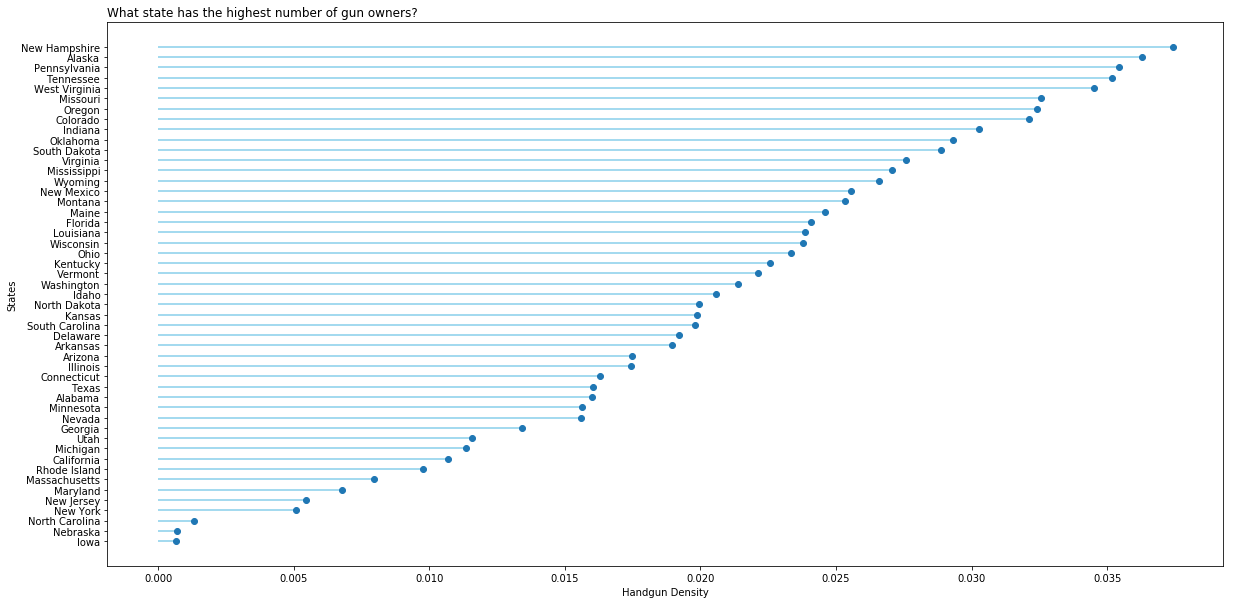

In [102]:
df_hd_sum = df['Handgun Density'].sum()
df_hd_per = (df['Handgun Density']/df_hd_sum).sort_values()
#df_hd_per.sort_values().plot(kind='Pie', figsize=(25,25))

my_range=range(1,len(df_hd_per.index)+1)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
plt.hlines(y=my_range, xmin=0, xmax=df_hd_per.values, color='skyblue')
plt.plot(df_hd_per.values, my_range, "o")

# Add title and exis names
plt.yticks(my_range, df_hd_per.index)
plt.title("What state has the highest number of gun owners?", loc='left')
plt.xlabel('Handgun Density')
plt.ylabel('States')

> The state with highest handgun density is New Hampshire

> The state with lowest handgun density is Iowa

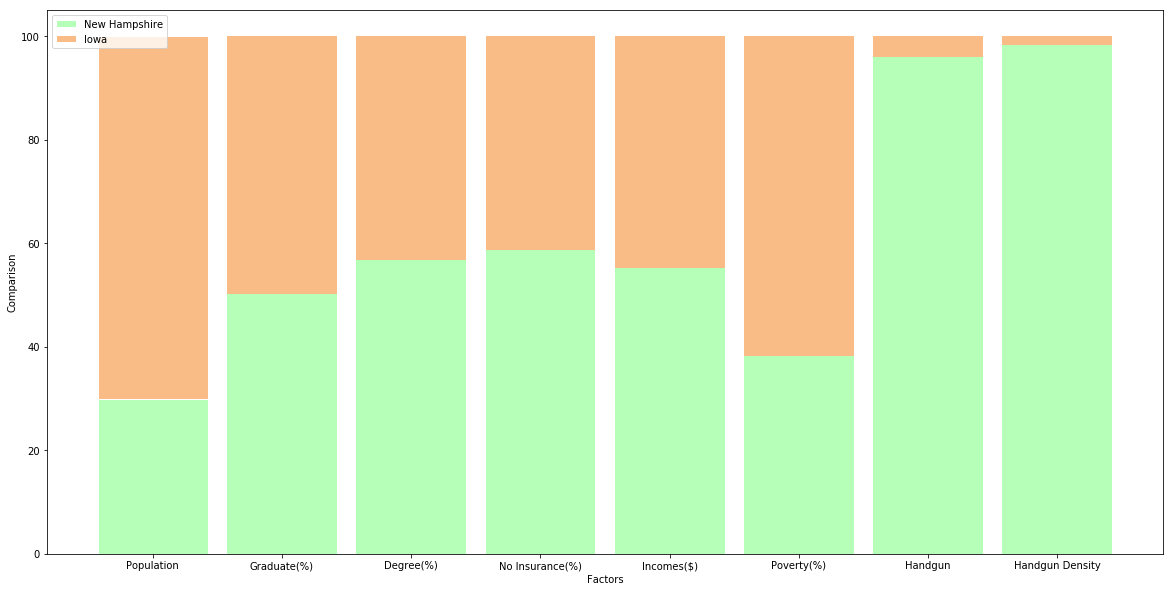

In [103]:
# Data
r = [0,1,2,3,4,5,6,7]
raw_data = {'New Hampshire': df.loc['New Hampshire'].values, 'Iowa': df.loc['Iowa'].values}

# From raw value to percentage
totals = [i+j for i,j in zip(df.loc['New Hampshire'], df.loc['Iowa'])]
greenBars = [i / j * 100 for i,j in zip(df.loc['New Hampshire'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df.loc['Iowa'], totals)]
 
# plot
barWidth = 0.85
names = df.columns.values

# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label='New Hampshire')
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label='Iowa')

# Custom x axis
plt.xticks(r, names)
plt.xlabel("Factors")
plt.ylabel("Comparison")
 
# Show graphic
plt.rcParams["figure.figsize"] = [20,10]
plt.legend()
plt.show()


> The differences between the two extreme states regarding the density of handgun are not very large in percentage. There is a slight better education and wealth level in 'New Hampshire' (the state with more weapons) aligned with previous observations

<a id='conclusions'></a>
## Conclusions

> As a final conclusion, there is no clear relationship in the chosen data (although it could initially appear)
Education and wealth influences but very little significantly, slightly homogenizing the differences between states

> This findings are tentative and you can not establish a clear causality without a deeper study

> It is necessary to perform more complex analyzes to give answers to the questions raised at the beginning of this analysis.
Analyze, for example, how the policy or the violence index might be interesting

> Data Reference:
The data comes from the FBI's
National Instant Criminal Background
Check System. The NICS is used by to
determine whether a prospective
buyer is eligible to buy firearms or
explosives. Gun shops call into this
system to ensure that each customer
does not have a criminal record or
isn’t otherwise ineligible to make a
purchase. The data has been
supplemented with state level data
from <a href="census.gov">census.gov</a>.

In [104]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0